# Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import tqdm.auto as tqdm
%matplotlib widget

In [2]:
def grab(x):
    """Convert torch tensor to numpy array"""
    return x.detach().cpu().numpy()

# Brief ML primer

Let's quickly demonstrate how training looks in Pytorch. We will train a small neural network to model the function
$$
f(x) = \mathrm{sinc}(x) := \frac{\sin(\pi x)}{\pi x}
$$

**EXERCISE:** We will improve the quality of the fit relative to the lecture by increasing the model size, training time, and width of the training distribution.

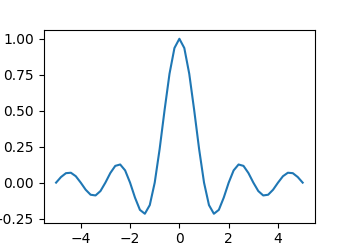

In [3]:
def target_fn(x):
    return torch.sinc(x)
fig, ax = plt.subplots(1,1, figsize=(3.5, 2.5))
xs = torch.linspace(-5, 5, steps=51)
ys = target_fn(xs)
ax.plot(grab(xs), grab(ys))
plt.show()

In [5]:
class ToyModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(1, 16),
            torch.nn.SiLU(),
            torch.nn.Linear(16, 16),
            torch.nn.SiLU(),
            torch.nn.Linear(16, 1),
        )
    def forward(self, x):
        assert len(x.shape) == 1, 'x should just have a batch index'
        return self.net(x[:,None])[:,0]

In [6]:
def train_model():
    model = ToyModel()
    batch_size = 128
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_hist = []
    for i in tqdm.tqdm(range(25000)):
        opt.zero_grad()
        # random samples around 0 for the training points
        x = 3*torch.randn((batch_size,))
        model_y = model(x)
        true_y = target_fn(x)
        # mean squared error
        loss = ((true_y - model_y)**2).mean()
        loss.backward()
        opt.step()
        loss_hist.append(grab(loss))
        if (i+1) % 1000 == 0:
            print(f'Step {i+1}: Loss {grab(loss)}')
    return dict(model=model, loss=np.stack(loss_hist))
res = train_model()

  0%|          | 0/25000 [00:00<?, ?it/s]

Step 1000: Loss 0.009693337604403496
Step 2000: Loss 0.005170689895749092
Step 3000: Loss 0.002907217014580965
Step 4000: Loss 0.0020951610058546066
Step 5000: Loss 0.001401347341015935
Step 6000: Loss 0.0013002017512917519
Step 7000: Loss 0.000816338462755084
Step 8000: Loss 0.0008245424833148718
Step 9000: Loss 0.0008694525458849967
Step 10000: Loss 0.0011084417346864939
Step 11000: Loss 0.0007744379108771682
Step 12000: Loss 0.0005825569969601929
Step 13000: Loss 0.0006664864486083388
Step 14000: Loss 0.000759713351726532
Step 15000: Loss 0.0006713676848448813
Step 16000: Loss 0.0006046310300007463
Step 17000: Loss 0.0004871613928116858
Step 18000: Loss 0.0008804594399407506
Step 19000: Loss 0.0004906715475954115
Step 20000: Loss 0.0005469396710395813
Step 21000: Loss 0.0003544023784343153
Step 22000: Loss 0.00029056635685265064
Step 23000: Loss 0.00034210592275485396
Step 24000: Loss 0.0006045211921446025
Step 25000: Loss 0.0003600894124247134


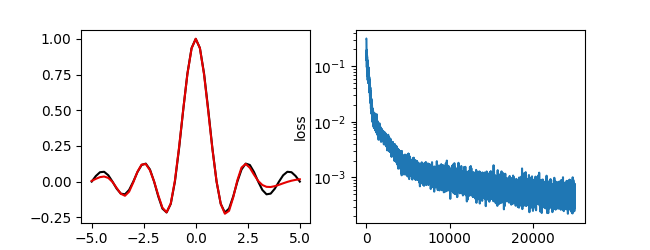

In [7]:
fig, axes = plt.subplots(1,2, figsize=(6.5, 2.5))
xs = torch.linspace(-5, 5, steps=51)
true_ys = target_fn(xs)
model_ys = res['model'](xs)
ax = axes[0]
ax.plot(grab(xs), grab(true_ys), color='k')
ax.plot(grab(xs), grab(model_ys), color='xkcd:red')
ax = axes[1]
ax.plot(res['loss'])
ax.set_ylabel('loss')
ax.set_yscale('log')
plt.show()

# Target

We will use a standard 2D target, a mixture of Gaussians:
$$
p(x) = \frac{1}{\sqrt{2\pi}} \sum_i \sigma(\alpha)_i e^{-(x-\mu_i)^2/2}.
$$
Above, $\sigma(\alpha)_i := e^{\alpha_i} / \sum_j e^{\alpha_j}$ is the Softmax function, which maps a vector $\vec{\alpha}$ to positive-definite and normalized weights.

In [8]:
class MixtureOfGaussians:
    def __init__(self, mu, alpha):
        assert mu.shape[-1] == 2
        assert mu.shape[0] == len(alpha)
        self.mu = mu
        self.logw = torch.nn.functional.log_softmax(alpha, dim=0)
    def log_prob(self, x):
        terms = self.logw -((x-self.mu)**2/2).sum(-1)
        return -0.5*np.log(2*np.pi) + torch.logsumexp(terms, dim=0)
    def sample(self, batch_size):
        x = torch.randn((batch_size,2))
        i = np.arange(len(self.logw))
        inds = np.random.choice(i, size=batch_size, p=np.exp(grab(self.logw)))
        # this indexing trick extracts the full 2d vectors at inds (see below)
        return x + self.mu[inds[:,None], np.arange(2)]

In [9]:
# this is an indexing trick that will be useful
a = np.arange(24).reshape(6, 4)
inds = np.array([1, 4, 3])
# this pulls rows "inds" out of a
extracted = a[inds[:,None], np.arange(4)]
print(f'{a=}')
print(' -> ')
print(f'{extracted=}')

a=array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [12, 13, 14, 15],
       [16, 17, 18, 19],
       [20, 21, 22, 23]])
 -> 
extracted=array([[ 4,  5,  6,  7],
       [16, 17, 18, 19],
       [12, 13, 14, 15]])


/Users/gkanwar/projects/flow-lectures/venv/lib/python3.13/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:4316.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


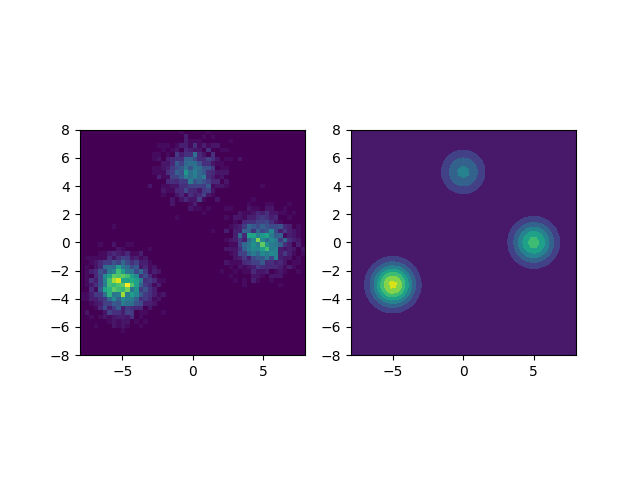

In [10]:
mu = torch.tensor([
    [5., 0.],
    [0, 5.],
    [-5., -3.]
])
alpha = torch.tensor([0.5, 0.0, 0.8])
target = MixtureOfGaussians(mu, alpha)
# samples
xs = grab(target.sample(4096))
fig, axes = plt.subplots(1, 2)
bins = np.linspace(-8, 8, num=51)
axes[0].hist2d(xs[:,0], xs[:,1], bins=bins)
# density
x_mesh = torch.stack(torch.meshgrid(torch.tensor(bins), torch.tensor(bins)), dim=-1)
x_flat = x_mesh.reshape(-1, 2)
logq = grab(torch.func.vmap(target.log_prob)(x_flat).reshape(51, 51))
x_mesh = grab(x_mesh)
axes[1].contourf(x_mesh[...,0], x_mesh[...,1], np.exp(logq))

for ax in axes:
    ax.set_aspect(1.0)
plt.show()

# Flow model

In [11]:
class Velocity(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(3, 8),
            torch.nn.SiLU(),
            torch.nn.Linear(8, 8),
            torch.nn.SiLU(),
            torch.nn.Linear(8, 2),
        )
    def value(self, x, t):
        # net expects a batch index
        inp = torch.cat([x, t[None]])
        return self.net(inp[None])[0]
    def div(self, x, t):
        # NOTE: for high dimensions, this is expensive!
        J = torch.func.jacfwd(self.value, argnums=0)(x, t)
        # div = trace of Jacobian
        return torch.trace(J)

From Lecture 1:

In [12]:
def flow(x, velocity, *, n_step, tf=1.0, inverse=False):
    dt = tf/n_step
    ts = dt*torch.arange(n_step)
    logJ = torch.tensor(0.0)
    sign = 1
    if inverse:
        sign = -1
        ts = reversed(ts)
    for t in ts:
        # transport samples
        x = x + sign * dt * velocity.value(x, t)
        # estimate change of measure
        logJ = logJ + dt * velocity.div(x, t)
    return x, logJ

**Training option 1:** Reverse KL divergence between target and model.

In [13]:
def train_model_rkl():
    torch.manual_seed(1234)
    model = Velocity()
    batch_size = 32
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_hist = []
    flow_batch = torch.func.vmap(flow, in_dims=(0, None))
    target_batch = torch.func.vmap(target.log_prob)
    for i in tqdm.tqdm(range(1000)):
        opt.zero_grad()
        # sample prior
        xr = torch.randn((batch_size, 2))
        logr = -(xr**2/2).sum(-1) - np.log(2*np.pi)
        # flow
        x, logJ = flow_batch(xr, model, n_step=10)
        logq = logr - logJ
        # kl divergence
        logp = target_batch(x)
        loss = (logq - logp).mean()
        loss.backward()
        opt.step()
        loss_hist.append(grab(loss))
        if (i+1) % 1000 == 0:
            print(f'Step {i+1}: Loss {grab(loss)}')
    return dict(model=model, loss=np.stack(loss_hist))
res_rkl = train_model_rkl()

  0%|          | 0/1000 [00:00<?, ?it/s]

Step 1000: Loss -0.11467066407203674


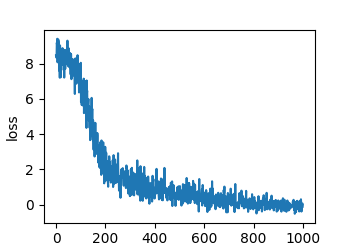

In [14]:
fig, ax = plt.subplots(1,1, figsize=(3.5, 2.5))
ax.plot(res_rkl['loss'])
ax.set_ylabel('loss')
ax.set_xlabel('iter')
plt.show()

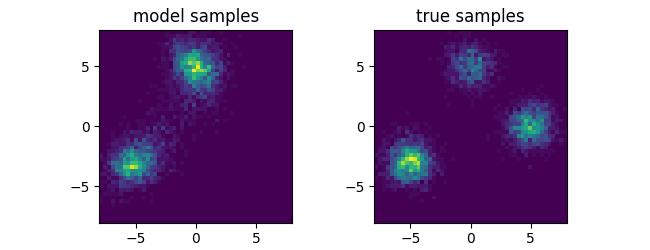

In [15]:
flow_batch = torch.func.vmap(flow, in_dims=(0, None))
xr = torch.randn((4096, 2))
x, logJ = flow_batch(xr, res_rkl['model'], n_step=10)
bins = np.linspace(-8, 8, num=51)
fig, axes = plt.subplots(1, 2, figsize=(6.5, 2.5))
axes[0].hist2d(grab(x)[:,0], grab(x)[:,1], bins=bins)
axes[0].set_title('model samples')
x2 = grab(target.sample(4096))
axes[1].hist2d(x2[:,0], x2[:,1], bins=bins)
axes[1].set_title('true samples')
for ax in axes:
    ax.set_aspect(1.0)
plt.show()

**EXERCISE:** Forward KL using samples from target. The training looks identical, except that we use samples from the target and change the loss function.

In [16]:
def train_model_fkl():
    torch.manual_seed(1234)
    model = Velocity()
    batch_size = 32
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_hist = []
    flow_batch = torch.func.vmap(flow, in_dims=(0, None))
    target_batch = torch.func.vmap(target.log_prob)
    for i in tqdm.tqdm(range(1000)):
        opt.zero_grad()
        # sample target
        x = target.sample(batch_size)
        xr, logJ = flow_batch(x, model, n_step=10, inverse=True)
        logr = -(xr**2/2).sum(-1) - np.log(2*np.pi)
        # kl divergence
        logq = logr - logJ
        logp = target_batch(x)
        # logp term is independent of model, we could drop it, but it normalizes
        # our loss function so the minimum is at zero
        loss = (logp - logq).mean()
        loss.backward()
        opt.step()
        loss_hist.append(grab(loss))
        if (i+1) % 1000 == 0:
            print(f'Step {i+1}: Loss {grab(loss)}')
    return dict(model=model, loss=np.stack(loss_hist))
res_fkl = train_model_fkl()

  0%|          | 0/1000 [00:00<?, ?it/s]

Step 1000: Loss 1.6492042541503906


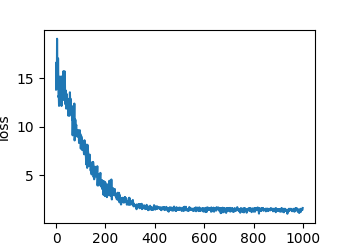

In [17]:
fig, ax = plt.subplots(1,1, figsize=(3.5, 2.5))
ax.plot(res_fkl['loss'])
ax.set_ylabel('loss')
ax.set_xlabel('iter')
plt.show()

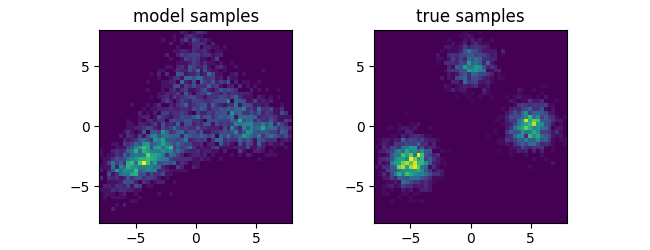

In [18]:
flow_batch = torch.func.vmap(flow, in_dims=(0, None))
xr = torch.randn((4096, 2))
x, logJ = flow_batch(xr, res_fkl['model'], n_step=10)
bins = np.linspace(-8, 8, num=51)
fig, axes = plt.subplots(1, 2, figsize=(6.5, 2.5))
axes[0].hist2d(grab(x)[:,0], grab(x)[:,1], bins=bins)
axes[0].set_title('model samples')
x2 = grab(target.sample(4096))
axes[1].hist2d(x2[:,0], x2[:,1], bins=bins)
axes[1].set_title('true samples')
for ax in axes:
    ax.set_aspect(1.0)
plt.show()